In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [4]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
config_path = "config/mcts_smiles.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.01, count_rollouts: 1, reward: 0.5452800125896784, node: CC(C)c1c(CNC(=O)c2cccc(Cl)c2)non1
1- time: 0.16, count_rollouts: 2, reward: -0.5454666852026875, node: O=C(Nc1nnccc1)N[C@@H]1CCCO1
2- time: 0.26, count_rollouts: 3, reward: -0.1354707289895729, node: NN(C(=O)c1ccccc1)C1CCN(C(=O)C2CCC2)C1
3- time: 2.44, count_rollouts: 17, reward: 0.5651753512110279, node: c1ccccc1C[C@@H](O)C(=O)c1ccc(OC)c(C)c1
4- time: 3.11, count_rollouts: 21, reward: 0.7685304556665766, node: Clc1ccc(Br)cc1CN(C)C(=O)NCc1ccc(Br)cc1
5- time: 4.93, count_rollouts: 33, reward: 0.7147249819573367, node: FCN(C(=O)c1ccc(CCS(=O)(=O)c2ccccc2)cc1)Nc1ccc(Br)cc1
6- time: 6.39, count_rollouts: 43, reward: 0.5757152230190613, node: F[C@@H](c1ccc(Cl)cc1)N1CCCC1
7- time: 7.56, count_rollouts: 51, reward: 0.5170318472748416, node: Sc1ccccc1CSc1nnc(C(=O)N2CCC2)s1
8- time: 9.14, count_rollouts: 60, reward: 0.01327857056402641, node: S[C@@H]1C[C@@H](NC(=O)N2CCCC2)CCN1C(=O)c1ccccc1
9- time: 11.94, coun

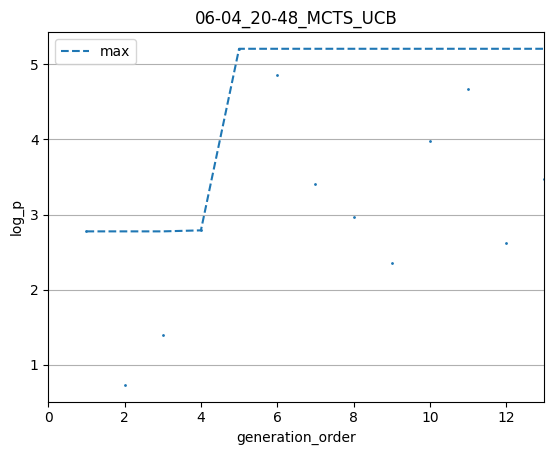

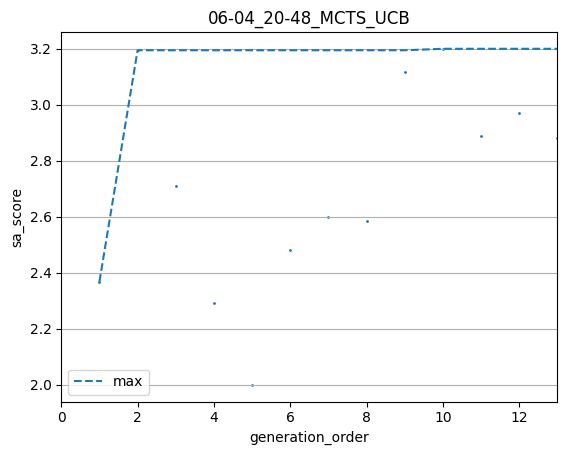

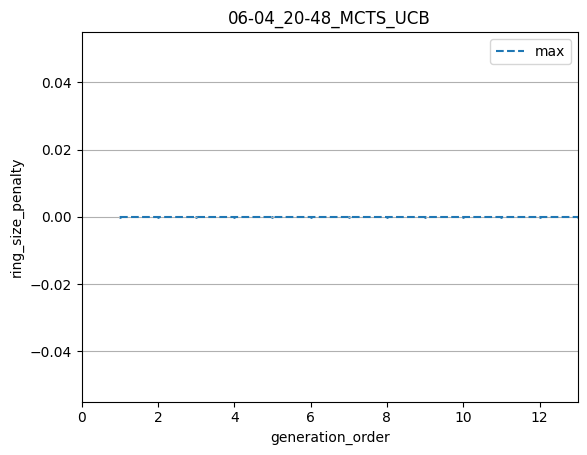

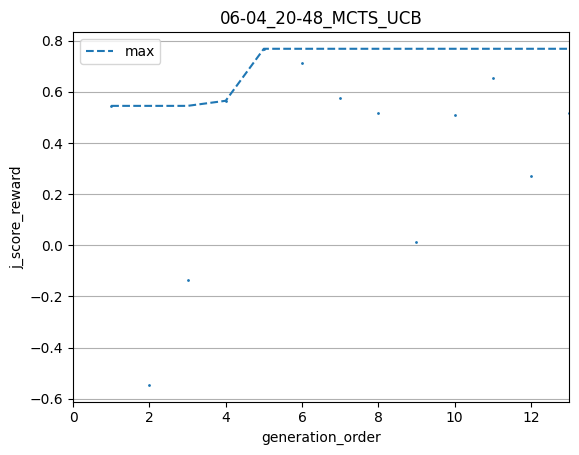

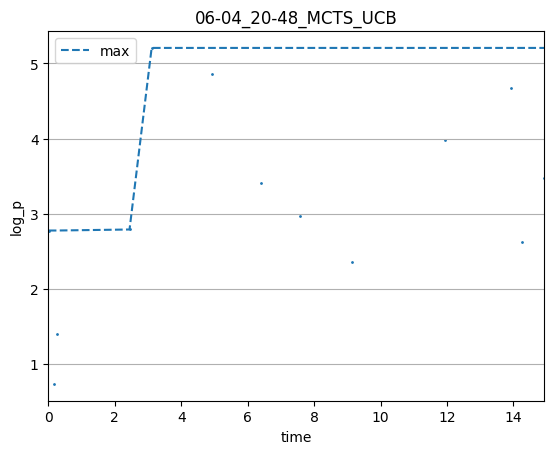

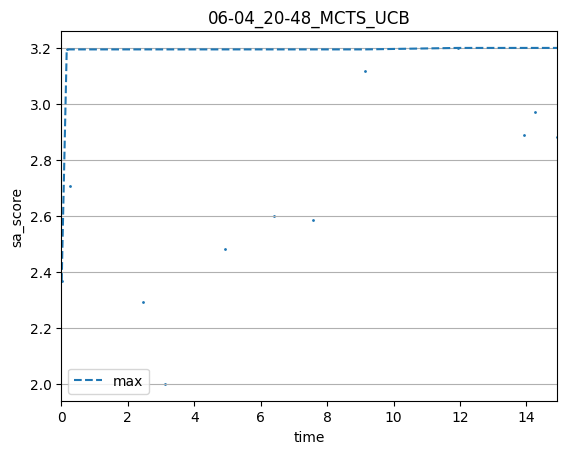

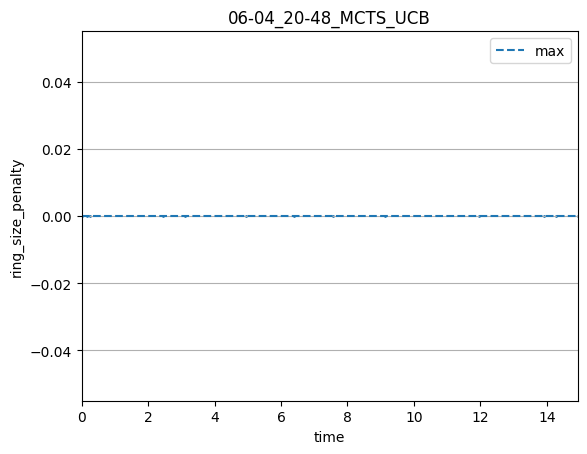

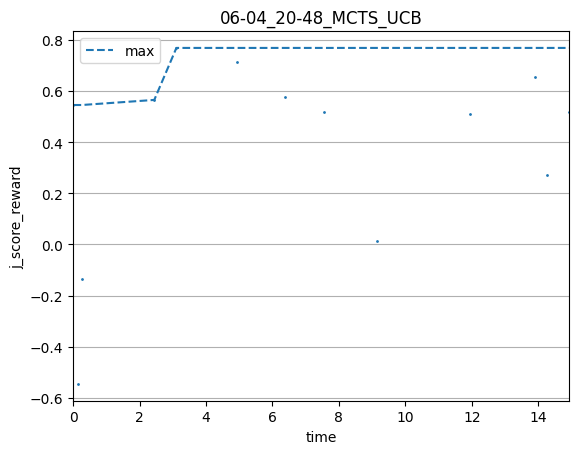

In [15]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)